In [30]:
#Imports 

import numpy as np 
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [31]:
print(os.getcwd())

/home/arunthakur/kochi-metro-sih/notebooks


In [32]:
DATA_DIR = "../data/training" 
datasets = {}

for file in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, file)
    name, ext = os.path.splitext(file)
    
    try:
        if ext.lower() == ".csv":
            datasets[name] = pd.read_csv(path)
        elif ext.lower() == ".json":
            datasets[name] = pd.read_json(path)
    except Exception as e:
        print(f" Error loading {file}: {e}")


Job Status Counts:
status
closed    138
open       62
Name: count, dtype: int64


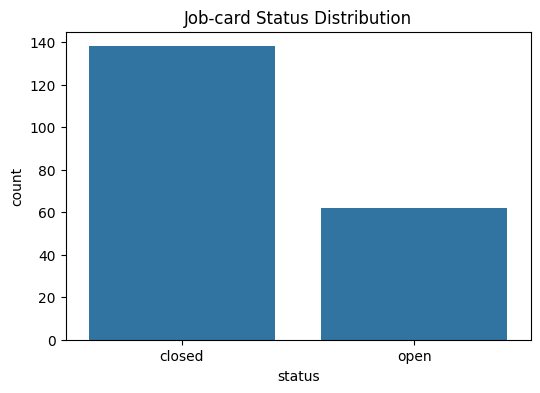

In [33]:
if "jobcard" in datasets:
    jc = datasets["jobcard"]
    print("\nJob Status Counts:")

    print(jc["status"].value_counts())
    
    plt.figure(figsize=(6,4))
    sns.countplot(x="status", data=jc)
    plt.title("Job-card Status Distribution")
    plt.show()


Fault Summary:
sensor_type  severity
HVAC         critical     3
             high         2
             low         26
             medium       4
brake        critical     5
             high         5
             low         20
             medium       5
door         high         5
             low         26
             medium       4
power        critical     4
             high         4
             low         24
             medium       3
signalling   critical     3
             high         1
             low         25
             medium       6
dtype: int64


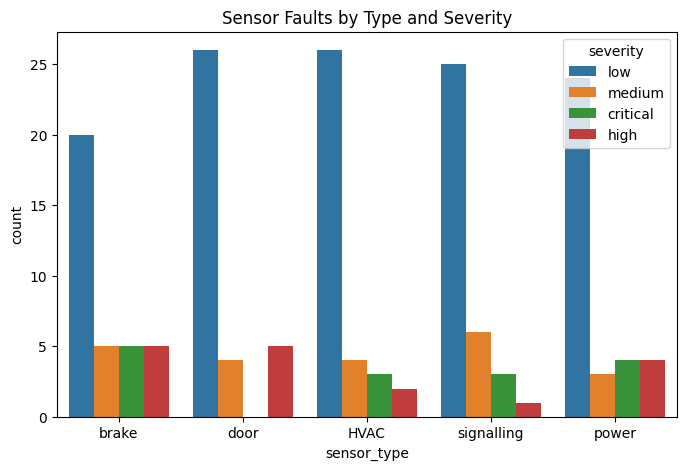

In [34]:
if "safety" in datasets:
    sf = datasets["safety"]
    print("\nFault Summary:")
    print(sf.groupby(["sensor_type", "severity"]).size())
    
    plt.figure(figsize=(8,5))
    sns.countplot(x="sensor_type", hue="severity", data=sf)
    plt.title("Sensor Faults by Type and Severity")
    plt.show()

In [35]:
if "maintenance" in datasets:
    ml = datasets["maintenance"]
    ml["last_maintenance_time"] = pd.to_datetime(ml["last_maintenance_time"], errors="coerce")
    now = datetime.now()
    ml["hours_since_last"] = (now - ml["last_maintenance_time"]).dt.total_seconds() / 3600
    
    print("\n🛠 Trains needing maintenance soon:")
    print(ml[ml["hours_since_last"] > ml["min_rest_hours"]])


🛠 Trains needing maintenance soon:
   train_id last_maintenance_time  min_rest_hours maintenance_type   status  \
0       T01   2025-09-07 14:30:00               8            minor  resting   
1       T02   2025-09-06 09:15:00              12            minor    ready   
2       T03   2025-09-05 16:45:00              24        scheduled    ready   
3       T04   2025-09-07 22:10:00               6            minor  resting   
4       T05   2025-09-04 11:20:00              36        scheduled    ready   
..      ...                   ...             ...              ...      ...   
75      T01   2025-09-02 16:20:00              18        scheduled  overdue   
76      T02   2025-09-07 12:45:00              10            minor  resting   
77      T03   2025-09-05 09:30:00               8            minor    ready   
78      T04   2025-09-06 23:15:00              20        scheduled  resting   
79      T05   2025-09-04 19:50:00              12            minor    ready   

    hours_since

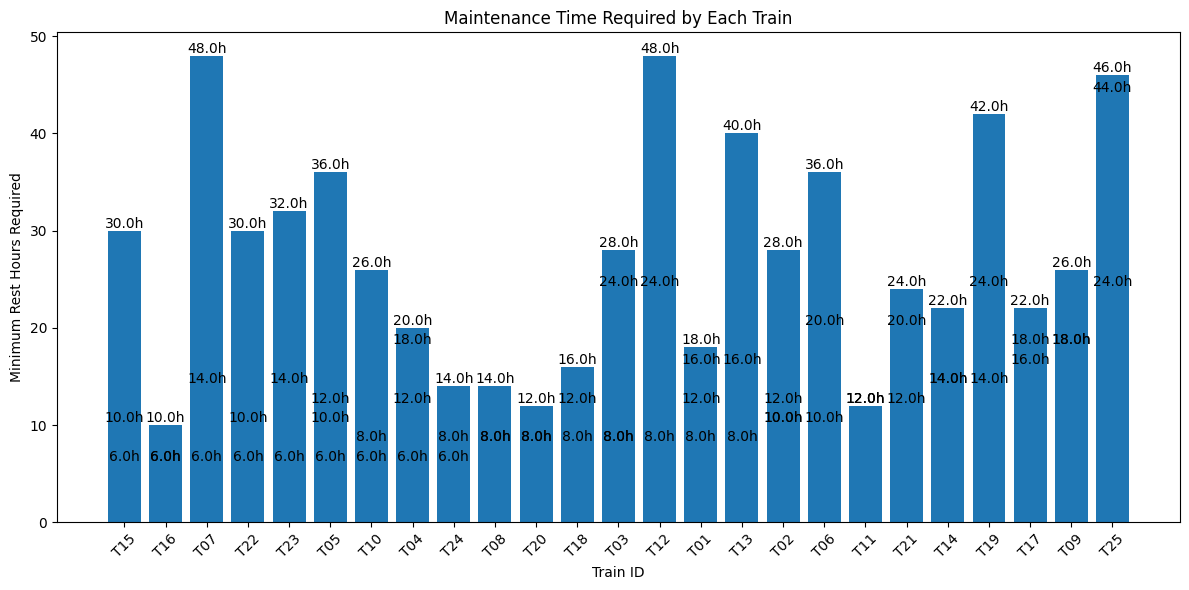


Trains sorted by maintenance time (shortest to longest):
train_id  min_rest_hours
     T15               6
     T16               6
     T07               6
     T22               6
     T23               6
     T05               6
     T10               6
     T16               6
     T04               6
     T24               6
     T08               8
     T20               8
     T24               8
     T18               8
     T10               8
     T03               8
     T03               8
     T12               8
     T20               8
     T01               8
     T13               8
     T08               8
     T22              10
     T16              10
     T02              10
     T15              10
     T02              10
     T05              10
     T06              10
     T05              12
     T20              12
     T11              12
     T04              12
     T11              12
     T21              12
     T01              12
     T02         

In [38]:
if "maintenance" in datasets:
    ml = datasets["maintenance"]
    ml["last_maintenance_time"] = pd.to_datetime(ml["last_maintenance_time"], errors="coerce")
    
    # Create a bar plot
    plt.figure(figsize=(12, 6))
    
    sorted_data = ml.sort_values('min_rest_hours')
    
    # Create bar plot
    bars = plt.bar(sorted_data['train_id'], sorted_data['min_rest_hours'])
    
    # Customize the plot
    plt.title('Maintenance Time Required by Each Train')
    plt.xlabel('Train ID')
    plt.ylabel('Minimum Rest Hours Required')
    plt.xticks(rotation=45)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}h',
                ha='center', va='bottom')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Print sorted list of trains by maintenance time
    print("\nTrains sorted by maintenance time (shortest to longest):")
    sorted_trains = sorted_data[['train_id', 'min_rest_hours']].to_string(index=False)
    print(sorted_trains)

In [ ]:
for name, df in datasets.items():
    print(f"\nDataset: {name}")
    print(df.head(5))
    print(df.info())
    print("-" * 50)


📊 Dataset: coupling
  train_id station  turnaround_time_min  coupling_time_min  \
0      T01     KCH                   12                  7   
1      T02     ALU                   11                  5   
2      T03     EKM                   13                  8   
3      T04     TCR                   10                  6   
4      T05     ERN                   14                  9   

   uncoupling_time_min            timestamp  
0                    6  2024-03-15 06:15:00  
1                    7  2024-03-15 06:22:00  
2                    5  2024-03-15 06:28:00  
3                    8  2024-03-15 06:35:00  
4                    6  2024-03-15 06:41:00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   train_id             107 non-null    object
 1   station              107 non-null    object
 2   turnaround_time_min  107 